!pip install pydantic
!pip install PyYAML
!pip install jinja2
!pip install visions
!pip install htmlmin
!pip install phik
!pip install requests
!pip install tqdm
!pip install seaborn
!pip install multimethod
!pip install statsmodels
!pip install typeguard
!pip install imagehash
!pip install wordcloud
!pip install dacite
!pip install numba

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd 
import seaborn as sns 
import statistics
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from ydata_profiling import ProfileReport

In [4]:
%matplotlib inline

In [5]:
modeldf2019 = pd.read_csv('mydata/MMSA2019.csv',encoding='latin-1',index_col=[0])
modeldf2021 = pd.read_csv('mydata/MMSA2021.csv',encoding='latin-1',index_col=[0])

In [6]:
#pd.set_option('display.max_columns', None)

In [7]:
pd.set_option('display.max_info_columns', 1000)
pd.set_option('display.max_info_rows', 1000000)

In [8]:
import io
buffer = io.StringIO()
modeldf2019.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210771 entries, 1 to 210771
Data columns (total 179 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    DISPCODE  210771 non-null  int64  
 1    STATERE1  71738 non-null   float64
 2    CELPHONE  71738 non-null   float64
 3    LADULT1   71738 non-null   float64
 4    COLGSEX   21 non-null      float64
 5    LANDSEX   30365 non-null   float64
 6    RESPSLCT  36285 non-null   float64
 7    SAFETIME  139033 non-null  float64
 8    CADULT1   139033 non-null  float64
 9    CELLSEX   139026 non-null  float64
 10   HHADULT   139028 non-null  float64
 11   SEXVAR    210771 non-null  int64  
 12   GENHLTH   210753 non-null  float64
 13   PHYSHLTH  210750 non-null  float64
 14   MENTHLTH  210761 non-null  float64
 15   POORHLTH  116171 non-null  float64
 16   HLTHPLN1  210764 non-null  float64
 17   PERSDOC2  210765 non-null  float64
 18   MEDCOST   210765 non-null  float64
 19   CHECKUP1  210763 non-

In [9]:
buffer = io.StringIO()
modeldf2021.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227792 entries, 1 to 227792
Data columns (total 152 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    DISPCODE  227792 non-null  int64  
 1    STATERE1  55524 non-null   float64
 2    CELPHON1  55524 non-null   float64
 3    LADULT1   55524 non-null   float64
 4    COLGSEX   18 non-null      float64
 5    LANDSEX   23345 non-null   float64
 6    RESPSLCT  30824 non-null   float64
 7    SAFETIME  172268 non-null  float64
 8    CADULT1   172268 non-null  float64
 9    CELLSEX   172267 non-null  float64
 10   HHADULT   172267 non-null  float64
 11   SEXVAR    227792 non-null  int64  
 12   GENHLTH   227790 non-null  float64
 13   PHYSHLTH  227790 non-null  float64
 14   MENTHLTH  227792 non-null  int64  
 15   POORHLTH  122851 non-null  float64
 16   PRIMINSR  227791 non-null  float64
 17   PERSDOC3  227792 non-null  int64  
 18   MEDCOST1  227791 non-null  float64
 19   CHECKUP1  227792 non-

### Merging 2019 and 2021 BRFSS Dataframes Using Columns of Interest

In [10]:
#Any variable with value counts below 14 with be turned to a categorical nominal datatype:
# Convert 'col1' from float to categorical
for col in modeldf2019.columns:
    if len(modeldf2019[col].value_counts()) < 15:
        modeldf2019[col] = modeldf2019[col].astype('category')
        
for col in modeldf2021.columns:
    if len(modeldf2021[col].value_counts()) < 15:
        modeldf2021[col] = modeldf2021[col].astype('category')
               

In [11]:
##Extract state from MMSANAME
def get_state(col):
    return col.split(',')[1]

modeldf2019['STATE'] = modeldf2019['MMSANAME'].apply(get_state)
modeldf2021['STATE'] = modeldf2021['MMSANAME'].apply(get_state)

In [12]:
columns = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1', '_HLTHPLN','PRIMINSR', '_RACE', 'MEDCOST1', 'MARITAL', '_EDUCAG', 
                'RENTHOM1', 'EMPLOY1', 'CHILDREN', '_INCOMG1', '_TOTINDA', 'CHCOCNCR', 'SMOKE100', 
                'SMOKDAY2', 'USENOW3','_SMOKER3', '_RFSMOK3','_RFBING5', 'DIABETE4','EXERANY2', 
                'CHCOCNCR', '_MICHD', '_RFHYPE6', '_RFCHOL3', 'ADDEPEV3', 'DECIDE','_AGE65YR', 
                'WTKG3', '_BMI5', '_BMI5CAT', '_SEX','STATE','SEQNO','_RFHLTH']
len(columns)

42

In [13]:
#RENAME COLUMNS in 2019 dataset to match 2021:
modeldf2019.rename(columns={'_INCOMG':'_INCOMG1','_RFHYPE5':'_RFHYPE6','HLTHPLN1': 'PRIMINSR','MEDCOST':'MEDCOST1',
                  '_RFCHOL2':'_RFCHOL3'},inplace=True)

In [14]:
#Create a _HLTHPLN from PRIMINSR IN 2019 df (- '_HLTHPLN' - Categorical variable for healthcare plan )

modeldf2019['_HLTHPLN'] = modeldf2019['PRIMINSR'].apply(lambda x: 1 if x in [1,2,3,4,5,6,7,8,9] 
                                                        else 2 if x == 88 else 'NA')

modeldf2019['_TOTINDA'] = modeldf2019['_TOTINDA'].astype(float)

#Create a DROCDY3_ from ALCDAY5 by dividing the ALCDAY5 variable by 7 days per week or 30 days per month
def compute_drocdy3_(x):
    # Handle NaN values
    if pd.isna(x):
        return np.nan
    
    x_int = int(str(x).split(".")[0])
    
    if x_int == 888:
        return 0.0
    elif x_int // 100 == 1:
        return (x_int % 100) / 7.0
    elif x_int // 100 == 2:
        return (x_int % 100) / 30.0
    elif x_int in [777, 999]:
        return np.nan
    else:
        return float(x_int)

modeldf2019['DROCDY3_'] = modeldf2019['ALCDAY5'].apply(compute_drocdy3_)
modeldf2021['DROCDY3_'] = modeldf2021['ALCDAY5'].apply(compute_drocdy3_)

In [15]:
# Get common columns
common_columns = modeldf2019.columns.intersection(modeldf2021.columns)

# Concatenate DataFrames based on common columns
brfss_df = pd.concat([modeldf2019[common_columns], modeldf2021[common_columns]],ignore_index=True )


In [16]:
#Convert appropriate columns into categories
# List of columns to convert
columns_list = ['_AGE65YR', '_INCOMG1', '_TOTINDA', '_HLTHPLN', '_RFBING5', 
                'PRIMINSR', '_EDUCAG', '_SMOKER3','_RFSMOK3','_SEX', '_RFHYPE6','PHYSHLTH',
                '_RFHLTH','MENTHLTH','_AGEG5YR','_ASTHMS1','_HISPANC','ALCDAY5',
                "CHECKUP1","CVDSTRK3","CHCSCNCR","CHCOCNCR","ADDEPEV3","CHCKDNY2", "DIABETE4",'_RACE']

# Convert each column to category data type in place
for col in columns_list:
    brfss_df[col] = brfss_df[col].astype('category')

#convert height to height in meters
def calculate_htinm(height3):
    if 300 <= height3 <= 311:
        htinm = ((height3 - 300) + 36)*0.0254
    elif 400 <= height3 <= 411:
        htinm = ((height3 - 400) + 48)*0.0254
    elif 500 <= height3 <= 511:
        htinm = ((height3 - 500) + 60)*0.0254
    elif 600 <= height3 <= 611:
        htinm = ((height3 - 600) + 72)*0.0254
    elif 700 <= height3 <= 711:
        htinm = ((height3 - 700) + 84)*0.0254
    else:
        htinm = None  # Handle cases that don't match any condition
    
    return htinm

brfss_df['HEIGHT3'] = brfss_df['HEIGHT3'].apply(calculate_htinm)


In [17]:
brfss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438563 entries, 0 to 438562
Data columns (total 136 columns):
 #    Column    Non-Null Count   Dtype   
---   ------    --------------   -----   
 0    DISPCODE  438563 non-null  category
 1    STATERE1  127262 non-null  category
 2    LADULT1   127262 non-null  float64 
 3    COLGSEX   39 non-null      category
 4    LANDSEX   53710 non-null   float64 
 5    RESPSLCT  67109 non-null   float64 
 6    SAFETIME  311301 non-null  category
 7    CADULT1   311301 non-null  category
 8    CELLSEX   311293 non-null  float64 
 9    HHADULT   311295 non-null  float64 
 10   SEXVAR    438563 non-null  category
 11   GENHLTH   438543 non-null  category
 12   PHYSHLTH  438540 non-null  category
 13   MENTHLTH  438553 non-null  category
 14   POORHLTH  239022 non-null  float64 
 15   PRIMINSR  438555 non-null  category
 16   MEDCOST1  438556 non-null  category
 17   CHECKUP1  438555 non-null  category
 18   BPMEDS    166060 non-null  category
 19   

In [18]:
#Lets make a copy of the merged dataframe
processed_features_df = brfss_df.copy()

#Place decimal place in fruit and vegetable columns (as it was implied)
def convert_decimal(x):
    if pd.isna(x):
        return np.nan
    else:
        return x/100
    
cols = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1','WTKG3','_BMI5']

#Convert features to appropriate values by placing the decimal place 
for col in cols:
    processed_features_df[col] = processed_features_df[col].apply(convert_decimal)
    
#Convert STATE column to US state
from States import states
processed_features_df['STATE'] = processed_features_df['STATE'].apply(lambda x: states[(x[-2:])] 
                                                                      if (x[-2:]) in states else x)

In [19]:
#list(processed_features_df['STATE'].unique())

### Generate EDA Report with Original Dataset

In [20]:
#profile = ProfileReport(modeldf2019)
#profile.to_file(output_file="mydata/EDA_Report_2019.html")

#profile = ProfileReport(modeldf2021)
#profile.to_file(output_file="mydata/EDA_Report_2021.html")

### Data Cleaning Handle Missing data

In [21]:
pd.reset_option('display.max_rows',None)

In [22]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.to_string())

           Total   Percent
COLGSEX   438524  0.999911
NUMPHON3  404391  0.922082
CAGEG     386802  0.881976
LANDSEX   384853  0.877532
DIABAGE3  383587  0.874645
ASTHNOW   376273  0.857968
RESPSLCT  371454  0.846980
PREGNANT  354313  0.807895
NUMHHOL3  311876  0.711132
STATERE1  311301  0.709820
LADULT1   311301  0.709820
ARTHDIS2  303726  0.692548
LMTJOIN3  303724  0.692544
ARTHEDU   303723  0.692541
JOINPAI2  303723  0.692541
ARTHEXER  303722  0.692539
HIVTSTD3  297800  0.679036
_FLSHOT7  284168  0.647953
_PNEUMO3  284168  0.647953
SMOKDAY2  275829  0.628938
BPMEDS    272503  0.621354
FLSHTMY3  229112  0.522415
MAXDRNKS  219485  0.500464
DRNK3GE5  219040  0.499449
AVEDRNK3  218304  0.497771
POORHLTH  199541  0.454988
CELLSEX   127270  0.290198
HHADULT   127268  0.290193
SAFETIME  127262  0.290180
CADULT1   127262  0.290180
_VEGESU1   60134  0.137116
_RFCHOL3   53817  0.122712
_FRUTSU1   50978  0.116239
VEGEDA2_   49591  0.113076
POTADA1_   48821  0.111320
_BMI5CAT   45787  0.104402
_

In [23]:
#Drop columns with more that 45% missing values 
col_more45 = list(missing_data.index[missing_data['Percent'] > 0.45])
col_more45
processed_features_df.drop(columns=col_more45,inplace=True)

#Drop columns that are of very low variance and have high unque vales and may be of no importance to ones health

processed_features_df.drop(columns=['SAFETIME','CELLSEX','DISPCODE','_MMSA','_MMSAWT'],inplace=True)
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438563 entries, 0 to 438562
Data columns (total 105 columns):
 #    Column    Non-Null Count   Dtype   
---   ------    --------------   -----   
 0    CADULT1   311301 non-null  category
 1    HHADULT   311295 non-null  float64 
 2    SEXVAR    438563 non-null  category
 3    GENHLTH   438543 non-null  category
 4    PHYSHLTH  438540 non-null  category
 5    MENTHLTH  438553 non-null  category
 6    PRIMINSR  438555 non-null  category
 7    MEDCOST1  438556 non-null  category
 8    CHECKUP1  438555 non-null  category
 9    CVDINFR4  438555 non-null  float64 
 10   CVDCRHD4  438556 non-null  float64 
 11   CVDSTRK3  438554 non-null  category
 12   ASTHMA3   438556 non-null  float64 
 13   CHCSCNCR  438556 non-null  category
 14   CHCOCNCR  438555 non-null  category
 15   ADDEPEV3  438555 non-null  category
 16   CHCKDNY2  438555 non-null  category
 17   DIABETE4  438556 non-null  category
 18   MARITAL   438529 non-null  category
 19   

##### Vegetable and fruit columns calculated from other veg_fruit columns (So we will keep only these ones)
     'FRNCHDA_'- french fry intake in time per day 2
     'POTADA1_' - computed potatoe servings per day 
     'FRUTDA2_',- number of fruits consunmed per day 
     'FTJUDA2_'- computed fruit juice intake in times per day 
     'VEGEDA2_', - COMPUTED NUMBER OF OTHER VEGIES eaten per day - not lettuce or potatoe 
     'GRENDA1_'- Number of dark green vegetables per day Times per day  
     'FRUTSU1', Number of Fruits consumed per day 
     'VEGESU1', Number of Vegetables consumed per day 


In [24]:
#Drop redundant Columns and irreleveant columns
processed_features_df.drop(columns=['SEQNO','_AGE80','_AGE65YR','_AGE_G','SEXVAR',
                                    'WEIGHT2','_CASTHM1','_LTASTH1','PRIMINSR','EXERANY2','CHILDREN','EDUCA',
                                    'ASTHMA3','SMOKE100','CPDEMO1B','_STSTR','CVDINFR4','CVDCRHD4','_RACEG21'
                                   ,'_RACEGR3','_PRACE1','_MRACE1','_IMPSEX','CADULT1','GENHLTH',
                                    'HHADULT','_RFBMI5','VEGETAB2','POTATOE1','FRENCHF1',
                                    'FVGREEN1','FRUITJU2','FRUIT2','HIVTST7'],inplace=True)

<Axes: >

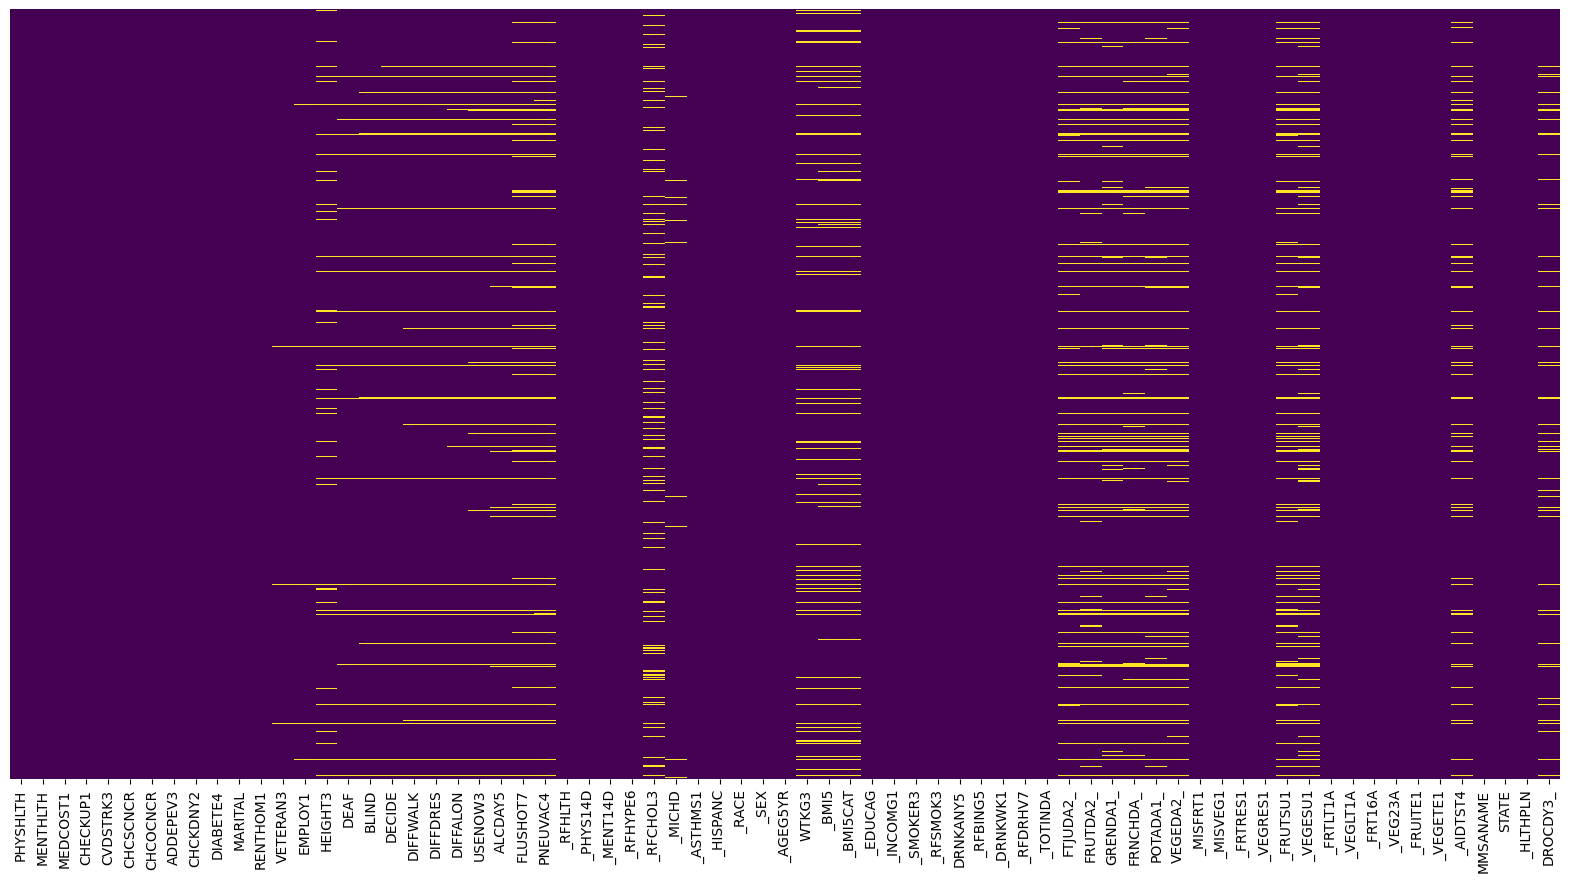

In [25]:
#vizualize misisng values using a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [26]:
#Drop the rows where columns have less than 5% missing values 
#list of columns with less than 5% missing data 

#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

col_less5miss = list(missing_data.index[missing_data['Percent'] < 0.05])
processed_features_df.dropna(subset=col_less5miss,inplace=True)

In [27]:
print(missing_data.to_string())

          Total   Percent
_VEGESU1  60134  0.137116
_RFCHOL3  53817  0.122712
_FRUTSU1  50978  0.116239
VEGEDA2_  49591  0.113076
POTADA1_  48821  0.111320
_BMI5     45787  0.104402
_BMI5CAT  45787  0.104402
FRNCHDA_  45286  0.103260
FTJUDA2_  44884  0.102343
GRENDA1_  44802  0.102156
FRUTDA2_  44402  0.101244
WTKG3     38540  0.087878
_AIDTST4  38393  0.087543
PNEUVAC4  36398  0.082994
FLUSHOT7  34963  0.079722
DROCDY3_  29332  0.066882
HEIGHT3   27209  0.062041
ALCDAY5   23696  0.054031
USENOW3   21352  0.048686
DIFFALON  19229  0.043845
DIFFDRES  18243  0.041597
DIFFWALK  17489  0.039878
DECIDE    16389  0.037370
BLIND     15355  0.035012
DEAF      14281  0.032563
_MICHD     4283  0.009766
EMPLOY1    3581  0.008165
VETERAN3   1672  0.003812
MARITAL      34  0.000078
PHYSHLTH     23  0.000052
RENTHOM1     20  0.000046
MENTHLTH     10  0.000023
CVDSTRK3      9  0.000021
CHCKDNY2      8  0.000018
CHECKUP1      8  0.000018
CHCOCNCR      8  0.000018
ADDEPEV3      8  0.000018
DIABETE4    

In [28]:
#replace the missing values in height with the mean for males and mean for females as it is normally distributed 

# Calculate mean height values for men and women separately
mean_height_men = processed_features_df[processed_features_df['_SEX'] == 1]['HEIGHT3'].mean()
mean_height_women = processed_features_df[processed_features_df['_SEX'] == 2]['HEIGHT3'].mean()

# Replace missing values with the corresponding mean height value
processed_features_df.loc[(processed_features_df['_SEX'] == 1) & (processed_features_df['HEIGHT3'].isnull()), 'HEIGHT3'] = mean_height_men
processed_features_df.loc[(processed_features_df['_SEX'] == 2) & (processed_features_df['HEIGHT3'].isnull()), 'HEIGHT3'] = mean_height_women

In [29]:
#replace the missing values in weight with the mean for males and mean for females as it is normally distributed 
#'WTKG3' - Weight in KG

# Calculate mean weight values for men and women separately
mean_height_men = processed_features_df[processed_features_df['_SEX'] == 1]['WTKG3'].mean()
mean_height_women = processed_features_df[processed_features_df['_SEX'] == 2]['WTKG3'].mean()

# Replace missing values with the corresponding mean weight value
processed_features_df.loc[(processed_features_df['_SEX'] == 1) & (processed_features_df['WTKG3'].isnull()), 'WTKG3'] = mean_height_men
processed_features_df.loc[(processed_features_df['_SEX'] == 2) & (processed_features_df['WTKG3'].isnull()), 'WTKG3'] = mean_height_women

In [30]:
#Fill in the missing _BMI5 values with the calculated value from weight and height 

# Replace missing values with the Calculated BMI value
processed_features_df['_BMI5'].fillna(processed_features_df['WTKG3'] / processed_features_df['HEIGHT3']**2, inplace=True)

#fill in the missing _BMICAT5 categories with the alotted categories based on _BMI5
def categorize_bmi(_BMI5):
    if 0.00 <= _BMI5 < 18.50:
        return 1
    elif 18.50 <= _BMI5 < 25.00:
        return 2
    elif 25.00 <= _BMI5 < 30.00:
        return 3
    elif _BMI5 >= 30.00:
        return 4
    else:
        return None  # Handle other possible cases (e.g. negative BMI or None)

processed_features_df['_BMI5CAT']= processed_features_df['_BMI5'].apply(categorize_bmi)
processed_features_df['_BMI5CAT'] = processed_features_df['_BMI5CAT'].astype('category')
processed_features_df.drop(columns='_BMI5',inplace=True)

In [31]:
#Drop rows where these columns are null
column_names = [
    "MENTHLTH",
    "ADDEPEV3",
    "CHECKUP1",
    "CVDSTRK3",
    "DIABETE4",
    "_HLTHPLN",
    "MEDCOST1",
    "CHCSCNCR",
    "CHCOCNCR",
    "CHCKDNY2",
    "_RACE"
]
processed_features_df.dropna(subset=column_names,inplace=True)

In [32]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#print(missing_data.to_string())

In [33]:
#Replace missing fruit and vegetable column values with the median value for each race & Age category assuming that
#different races and ages tend to have different diets
fruit_veg_columns = [
    '_VEGESU1',
    '_FRUTSU1',
    'VEGEDA2_',
    'POTADA1_',
    'FRNCHDA_',
    'FTJUDA2_',
    'GRENDA1_',
    'FRUTDA2_']

for col in fruit_veg_columns:
    medians = processed_features_df.groupby(['_RACE', '_AGEG5YR'])[col].transform('median')
    processed_features_df[col].fillna(medians, inplace=True)


In [34]:
#The missing values in _RFCHOL3 are filled in a way that preserves the ratio of its subcategories. 
#This can be useful if you believe that the observed distribution is representative and want 
#the filled values to reflect that same distribution.

# Find distribution of non-missing values
value_counts = processed_features_df['_RFCHOL3'].value_counts(normalize=True)

# Fill missing values by sampling based on this distribution
missing_count = processed_features_df['_RFCHOL3'].isna().sum()
if missing_count > 0:
    imputed_values = np.random.choice(value_counts.index, 
                                      p=value_counts.values, 
                                      size=missing_count)
    processed_features_df.loc[processed_features_df['_RFCHOL3'].isna(), '_RFCHOL3'] = imputed_values

In [35]:
#Drop all rows with any NA values 
processed_features_df.dropna(inplace=True)
#processed_features_df.info()

<Axes: >

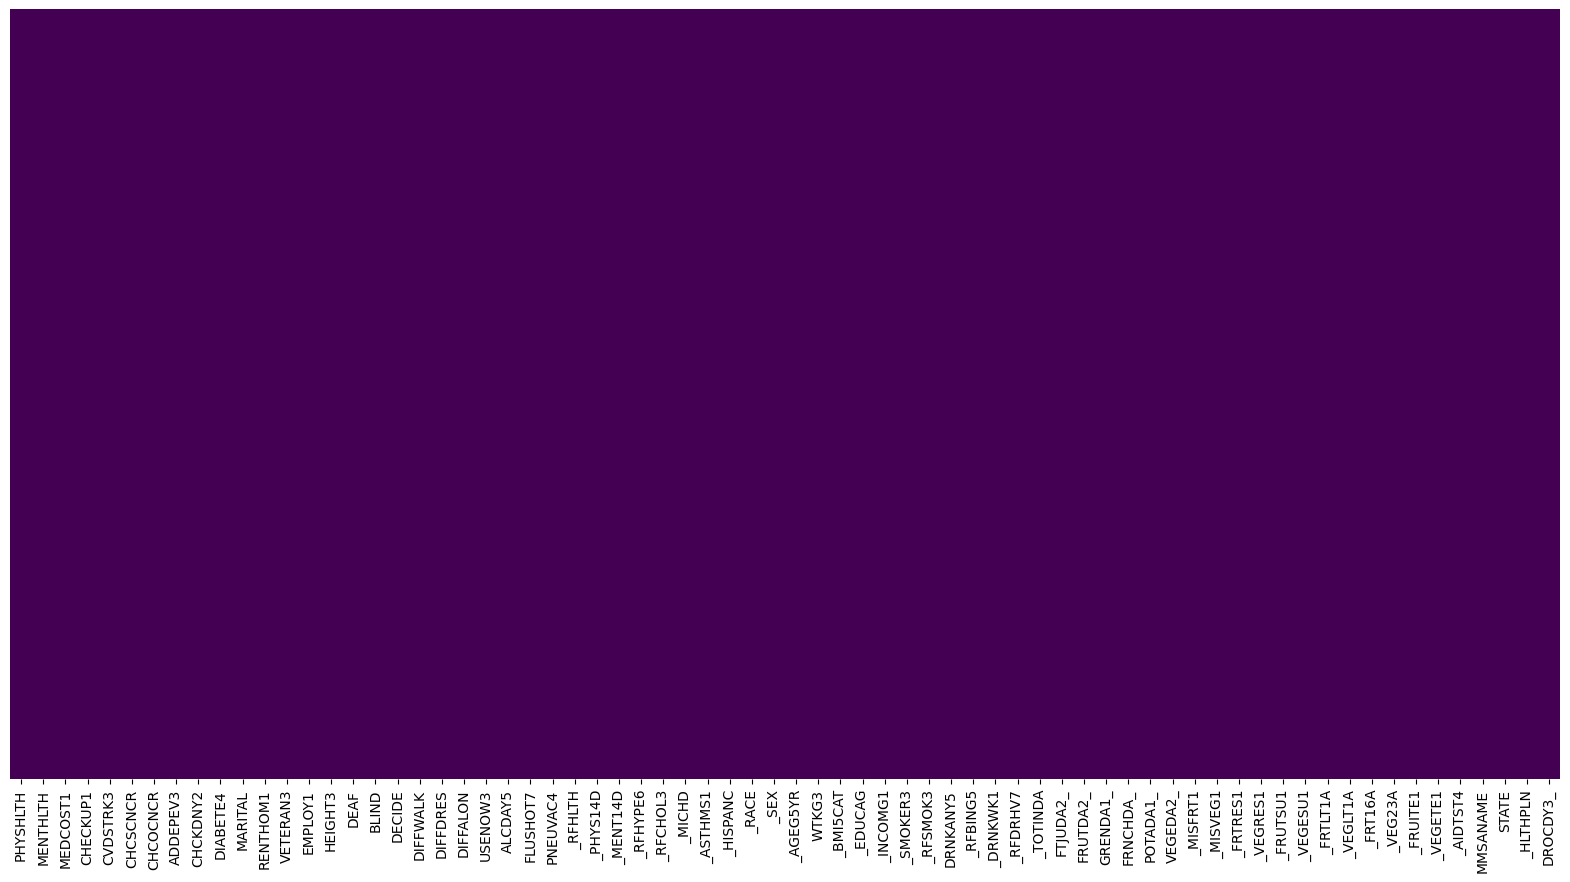

In [36]:
#vizualize misisng values using a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [37]:
#Lets Generate A profile report of the cleaned data
profile = ProfileReport(processed_features_df,minimal=True,dark_mode=True)
profile.to_file(output_file="EDA_Report_Cleaned.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391231 entries, 0 to 438562
Data columns (total 70 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   PHYSHLTH  391231 non-null  category
 1   MENTHLTH  391231 non-null  category
 2   MEDCOST1  391231 non-null  category
 3   CHECKUP1  391231 non-null  category
 4   CVDSTRK3  391231 non-null  category
 5   CHCSCNCR  391231 non-null  category
 6   CHCOCNCR  391231 non-null  category
 7   ADDEPEV3  391231 non-null  category
 8   CHCKDNY2  391231 non-null  category
 9   DIABETE4  391231 non-null  category
 10  MARITAL   391231 non-null  category
 11  RENTHOM1  391231 non-null  category
 12  VETERAN3  391231 non-null  category
 13  EMPLOY1   391231 non-null  category
 14  HEIGHT3   391231 non-null  float64 
 15  DEAF      391231 non-null  category
 16  BLIND     391231 non-null  category
 17  DECIDE    391231 non-null  category
 18  DIFFWALK  391231 non-null  category
 19  DIFFDRES  391231 non-nu

In [49]:
processed_features_df.describe([0.25,0.50,0.75,0.99]).T

,count,mean,std,min,25%,50%,75%,99%,max
HEIGHT3,391231.0,1.701693,0.105403,0.9144,1.6256,1.701800,1.778,1.9304,2.413
WTKG3,391231.0,82.049772,20.470791,22.6800,68.0400,79.380000,90.720,145.1500,285.760
_DRNKWK1,391231.0,1196.809350,9495.925849,0.0000,0.0000,23.000000,280.000,11200.0000,99900.000
FTJUDA2_,391231.0,0.392526,2.917306,0.0000,0.0000,0.030000,0.290,3.0000,99.000
FRUTDA2_,391231.0,1.290973,4.052397,0.0000,0.4300,1.000000,1.000,5.0000,99.000
GRENDA1_,391231.0,0.746421,3.842434,0.0000,0.1400,0.430000,0.710,4.0000,99.000
FRNCHDA_,391231.0,0.227543,1.278219,0.0000,0.0300,0.140000,0.290,1.0000,99.000
POTADA1_,391231.0,0.251712,1.356837,0.0000,0.0700,0.140000,0.290,1.0000,99.000
VEGEDA2_,391231.0,1.241166,5.126617,0.0000,0.4300,1.000000,1.000,7.0000,99.000
_FRUTSU1,391231.0,1.673102,5.514396,0.0000,0.5700,1.000000,2.000,7.0700,198.000


In [56]:
# Replace outliers with the 99 percentile value except weight column

num_cols = ['HEIGHT3','_DRNKWK1','FTJUDA2_','FRUTDA2_','GRENDA1_','FRNCHDA_',
            'POTADA1_','VEGEDA2_','_FRUTSU1','_VEGESU1','DROCDY3_']

for i in num_cols:
    percentile_99 = np.percentile(processed_features_df[i], 99)
    processed_features_df.loc[processed_features_df[i] > percentile_99, i] = percentile_99


In [58]:
processed_features_df.describe([0.25,0.50,0.75,0.99]).T

,count,mean,std,min,25%,50%,75%,99%,max
HEIGHT3,391231.0,1.701268,0.104287,0.9144,1.6256,1.701800,1.778,1.9304,1.9304
WTKG3,391231.0,82.049772,20.470791,22.6800,68.0400,79.380000,90.720,145.1500,285.7600
_DRNKWK1,391231.0,382.774392,1263.284201,0.0000,0.0000,23.000000,280.000,11200.0000,11200.0000
FTJUDA2_,391231.0,0.277943,0.504339,0.0000,0.0000,0.030000,0.290,3.0000,3.0000
FRUTDA2_,391231.0,1.094468,0.969041,0.0000,0.4300,1.000000,1.000,5.0000,5.0000
GRENDA1_,391231.0,0.563276,0.615586,0.0000,0.1400,0.430000,0.710,4.0000,4.0000
FRNCHDA_,391231.0,0.189088,0.222347,0.0000,0.0300,0.140000,0.290,1.0000,1.0000
POTADA1_,391231.0,0.209298,0.228036,0.0000,0.0700,0.140000,0.290,1.0000,1.0000
VEGEDA2_,391231.0,0.956261,0.975160,0.0000,0.4300,1.000000,1.000,7.0000,7.0000
_FRUTSU1,391231.0,1.391998,1.221601,0.0000,0.5700,1.000000,2.000,7.0700,7.0700


<Axes: >

<Figure size 1200x800 with 0 Axes>

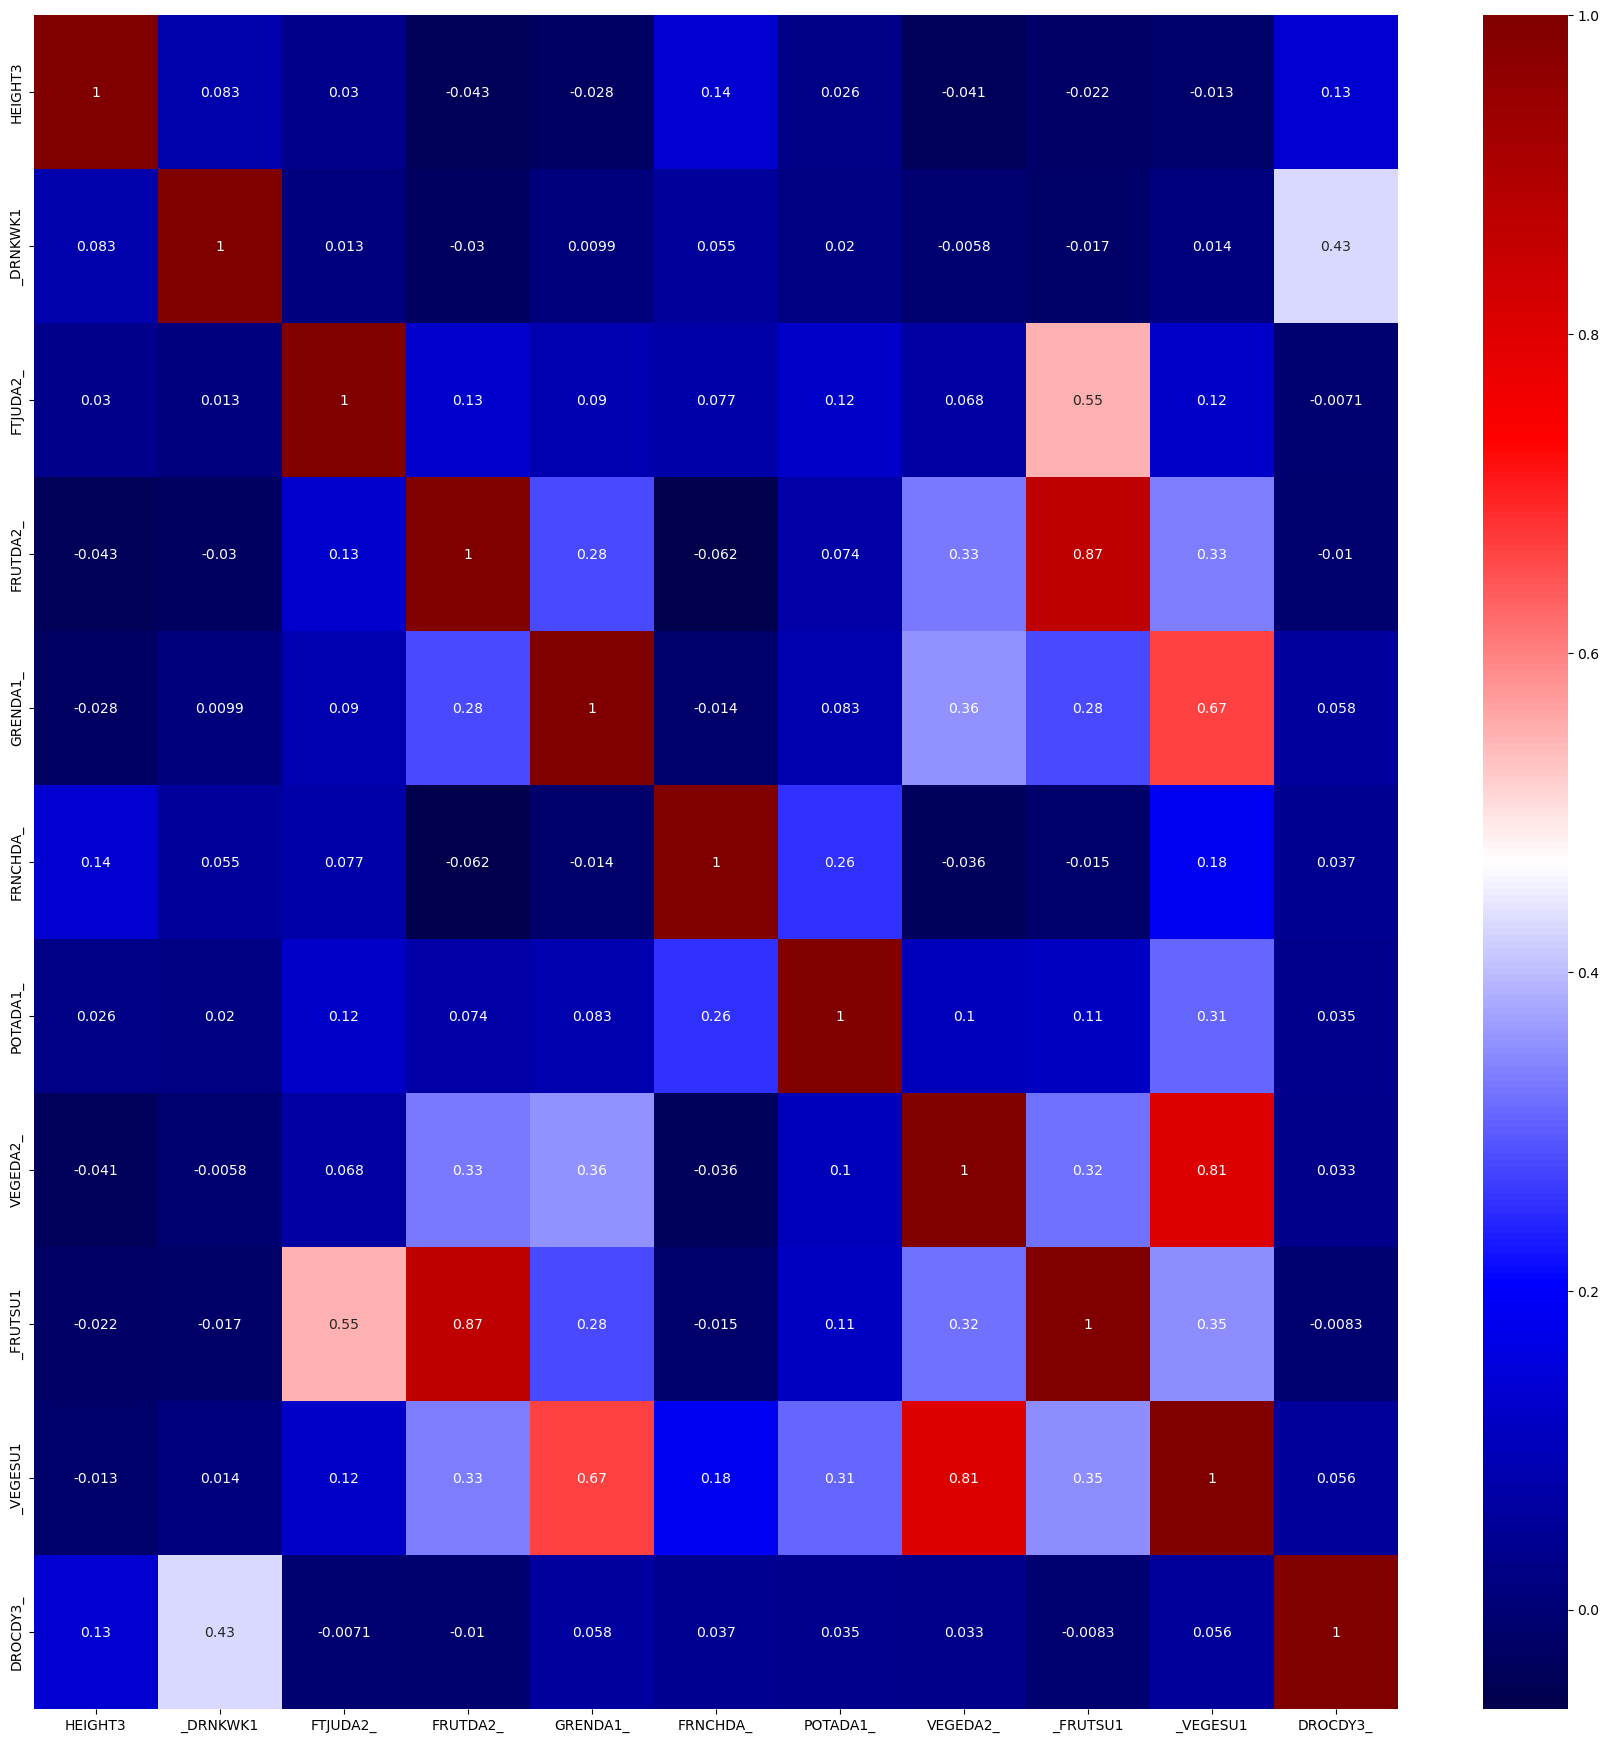

In [62]:
#Chesk for correlation between the numeric vairbales 
plt.figure(figsize=(12,8))
plt.figure(figsize=(22,22))
sns.heatmap(processed_features_df[num_cols].corr(),cmap='seismic',annot=True)

- We can see the presence of significant multicolinearity between the fruits and vegetable columns, which we will
look to remove further down the line 

#### Export the processed df out to be split into training and validation data

In [63]:
processed_features_df.to_csv('mydata/MMSA2019_2021_Cleaned.csv', index=False)